In [155]:
import os.path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error as mse_sklearn
from sklearn.metrics import mean_absolute_error as mae_sklearn

In [156]:
use_GPU = torch.cuda.is_available()
if use_GPU:
    mode = {"name": "cuda", "device": torch.device("cuda")}
else:
    mode = {"name": "cpu", "device": torch.device("cpu")}

in_dim = 1
hidden_dim = 64
out_dim = 1
sequence_length = 12
batch_size = 128 # 32, 64, 128, 256

num_epochs=10
num_workers=11
lr = 1e-3
regularization=1e-6

In [157]:
def get_data(path):
    data = []
    for i in ["train", "val", "test"]:
        data.append(pd.read_csv(path + i + ".csv", index_col="Datetime"))
    return data[0], data[1], data[2]
# Load data
path = '../data/clean_data/univariate_Q_Kallveit/'
train, val, test = get_data(path)
train

,Q_Kalltveit
Datetime,
2015-01-01 00:00:00,3.37060
2015-01-01 01:00:00,3.45242
2015-01-01 02:00:00,3.56260
2015-01-01 03:00:00,3.74423
2015-01-01 04:00:00,4.02901
...,...
2020-01-20 16:00:00,7.14669
2020-01-20 17:00:00,7.45883
2020-01-20 18:00:00,7.81983


In [158]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [159]:
X_train, y_train = sliding_windows(train.values, sequence_length)
X_val, y_val = sliding_windows(val.values, sequence_length)
X_test, y_test = sliding_windows(test.values, sequence_length)

X_train, X_val, X_test = X_train.reshape(len(X_train), -1), X_val.reshape(len(X_val), -1), X_test.reshape(len(X_test), -1)
print(X_train.shape, X_val.shape, X_test.shape)

(44288, 12) (13277, 12) (5684, 12)


In [160]:
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=(0,0,0),std=(1,1,1))])

In [161]:
from torch.utils.data import Dataset
import torch

class data_trans(Dataset):
        
    def __init__(self, data, groundtruth, transform=None):

        self.data = self._get_data(data)
        self.groundtruth = self._get_data(groundtruth)
        self.transform = transform

    def _get_data(self,data):
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self,index):
               
        inputs = self.data[index,:]
        groundtruths = self.groundtruth[index,:]
        
        if self.transform:
                        
            inputs = torch.from_numpy(inputs).float()
            groundtruths = torch.from_numpy(groundtruths).float()
                       
        return [inputs, groundtruths]

In [162]:
train_data_trans = data_trans(X_train, y_train, transform)
val_data_trans = data_trans(X_val, y_val, transform)
test_data_trans = data_trans(X_test, y_test, transform)

In [163]:
train_dataloader = torch.utils.data.DataLoader(train_data_trans,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           num_workers = 0)
val_dataloader = torch.utils.data.DataLoader(val_data_trans,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           num_workers = 0)
test_dataloader = torch.utils.data.DataLoader(test_data_trans,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           num_workers = 0)

In [164]:
data_loader = {
    "train": train_dataloader,
    "val": val_dataloader,
    "test": test_dataloader,
}

In [165]:
class FCN(nn.Module):
    
    def __init__(self, in_dim, hidden_dim, out_dim, sequence_length):

        super(FCN, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.sequence_length = sequence_length

        self.layer_in = nn.Linear(sequence_length, hidden_dim, bias=False)
        self.fcn = nn.Linear(hidden_dim, hidden_dim)
        self.layer_out = nn.Linear(hidden_dim, out_dim, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward (self,input):
        out = self.layer_in(input)
        out = self.sigmoid(out)
        out = self.fcn(out)
        out = self.sigmoid(out)
        out = self.layer_out(out)
      
        return out

In [166]:
class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, sequence_length):
        super(LSTM, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.sequence_length = sequence_length
        
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(in_dim, hidden_dim)
        self.lstm2 = nn.LSTMCell(hidden_dim, hidden_dim)
        
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear_out = nn.Linear(hidden_dim*sequence_length, out_dim)

        
    def forward(self, y):
        outputs = []
        h_t = torch.zeros(y.size(0), self.hidden_dim, dtype=torch.float32).to(mode["device"])
        c_t = torch.zeros(y.size(0), self.hidden_dim, dtype=torch.float32).to(mode["device"])
        h_t2 = torch.zeros(y.size(0), self.hidden_dim, dtype=torch.float32).to(mode["device"])
        c_t2 = torch.zeros(y.size(0), self.hidden_dim, dtype=torch.float32).to(mode["device"])
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        out = self.linear_out(outputs)
        return out

In [167]:
class LSTM2(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, sequence_length):
        super(LSTM2, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.sequence_length = sequence_length

        self.lstm1 = nn.LSTMCell(in_dim, hidden_dim)
        self.lstm2 = nn.LSTMCell(hidden_dim, hidden_dim)

        self.T_A = nn.Linear(sequence_length*hidden_dim, sequence_length)
        
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear_out = nn.Linear(hidden_dim, out_dim)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, y):
        outputs = []
        h_t = torch.zeros(y.size(0), self.hidden_dim).to(mode["device"])
        c_t = torch.zeros(y.size(0), self.hidden_dim).to(mode["device"])
        h_t2 = torch.zeros(y.size(0), self.hidden_dim).to(mode["device"])
        c_t2 = torch.zeros(y.size(0), self.hidden_dim).to(mode["device"])
        
        for time_step in y.split(1, dim=1):
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        total_ht = outputs[0]
        for i in range(1, len(outputs)):
            total_ht = torch.cat((total_ht, outputs[i]), 1)

        beta_t =  self.relu(self.T_A(total_ht))
        beta_t = self.softmax(beta_t)

        out = torch.zeros(y.size(0), self.hidden_dim)

        for i in range(len(outputs)):
                      
            out = out + outputs[i]*beta_t[:,i].reshape(out.size(0), 1)

        out = self.linear_out(out)
        
        return out

In [168]:
from tqdm import tqdm
from torchmetrics.functional import mean_absolute_error

def fit(model, loss_function, optimizer, data_loader, num_epochs, mode, use_amp=False):
	history = {"train": {"loss": [], "mae": []}, "val": {"loss": [], "mae": []}}
	scaler = torch.cuda.amp.GradScaler(enabled=use_amp) # Mixed-precision support for compatible GPUs
	print("\nTraining the model:")
	for epoch in range(num_epochs):
		
		print("\nEpoch", epoch+1)
		if epoch < num_epochs - 1:
			keys = ["train", "val"]
		else:
			keys = ["train", "val", "test"]
		for key in keys:
			dataset_size = 0
			dataset_loss = 0.0
			#dataset_mae = []
			if key == "train":
				model.train()
			else:
				model.eval()
			for X_batch, y_batch in tqdm(data_loader[key]):
				X_batch, y_batch = X_batch.to(mode["device"]), y_batch.to(mode["device"])
				with torch.set_grad_enabled(mode=(key=="train")): # Autograd activated only during training
					with torch.cuda.amp.autocast(enabled=use_amp): # Mixed-precision support for compatible GPUs
						batch_output = model(X_batch.float())
						batch_loss = loss_function(batch_output, y_batch)
					if key == "train":
						scaler.scale(batch_loss).backward()
						scaler.step(optimizer) 	
						scaler.update()
						optimizer.zero_grad()
				dataset_size += y_batch.shape[0]
				dataset_loss += y_batch.shape[0] * batch_loss.item()
				#dataset_mae += mean_absolute_error(batch_output, y_batch).item()
			dataset_loss /= dataset_size
			#dataset_mae /= dataset_size
			if key in ["train", "val"]:
				history[key]["loss"].append(dataset_loss)
				#history[key]["mae"].append(dataset_mae)
			else:
				print("\nEvaluating the model:")
			print(key, "loss:", dataset_loss, "    ", 
					#key, "mae:", dataset_mae
					)
	return history


In [169]:
model_1 = FCN(in_dim, hidden_dim, out_dim, sequence_length).to(mode["device"])
optimizer = optimizer = optim.Adam(model_1.parameters(), lr=lr, weight_decay=regularization)
error_criterion = nn.MSELoss().to(mode["device"])

history = fit(model=model_1, loss_function=error_criterion, optimizer=optimizer, data_loader=data_loader, num_epochs=num_epochs, mode=mode)



Training the model:

Epoch 1


100%|██████████| 346/346 [00:01<00:00, 304.06it/s]


train loss: 64.91553943669908     


100%|██████████| 104/104 [00:00<00:00, 565.54it/s]


val loss: 53.44503993547007     

Epoch 2


100%|██████████| 346/346 [00:01<00:00, 328.25it/s]


train loss: 57.328395674683456     


100%|██████████| 104/104 [00:00<00:00, 616.10it/s]


val loss: 51.59518926779513     

Epoch 3


100%|██████████| 346/346 [00:00<00:00, 347.04it/s]


train loss: 55.43097268053562     


100%|██████████| 104/104 [00:00<00:00, 587.93it/s]


val loss: 48.64850367143623     

Epoch 4


100%|██████████| 346/346 [00:01<00:00, 321.01it/s]


train loss: 49.77184887047362     


100%|██████████| 104/104 [00:00<00:00, 598.54it/s]


val loss: 39.84851476888821     

Epoch 5


100%|██████████| 346/346 [00:00<00:00, 346.95it/s]


train loss: 39.91512269539842     


100%|██████████| 104/104 [00:00<00:00, 544.51it/s]


val loss: 28.21566901147397     

Epoch 6


100%|██████████| 346/346 [00:01<00:00, 314.92it/s]


train loss: 30.99228480357187     


100%|██████████| 104/104 [00:00<00:00, 625.70it/s]


val loss: 21.025111757931796     

Epoch 7


100%|██████████| 346/346 [00:01<00:00, 318.31it/s]


train loss: 26.109146783359865     


100%|██████████| 104/104 [00:00<00:00, 537.35it/s]


val loss: 16.55277801980305     

Epoch 8


100%|██████████| 346/346 [00:01<00:00, 314.53it/s]


train loss: 22.782793166071468     


100%|██████████| 104/104 [00:00<00:00, 623.96it/s]


val loss: 13.185053018413255     

Epoch 9


100%|██████████| 346/346 [00:01<00:00, 340.54it/s]


train loss: 20.008189117917496     


100%|██████████| 104/104 [00:00<00:00, 561.81it/s]


val loss: 10.51718987252541     

Epoch 10


100%|██████████| 346/346 [00:01<00:00, 325.22it/s]


train loss: 17.77259750981138     


100%|██████████| 104/104 [00:00<00:00, 627.67it/s]


val loss: 8.601829201978273     


100%|██████████| 45/45 [00:00<00:00, 641.42it/s]


Evaluating the model:
test loss: 14.46655802577629     


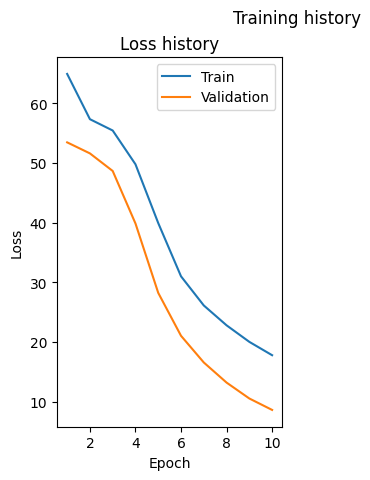

In [170]:
def print_history(history):
	absciss = np.arange(1, len(history["train"]["loss"])+1)
	plt.figure()
	plt.suptitle("Training history")
	plt.subplot(121)
	plt.title("Loss history")
	plt.plot(absciss, history["train"]["loss"], label="Train")
	plt.plot(absciss, history["val"]["loss"], label="Validation")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.show()
print_history(history)

In [171]:
model_2 = LSTM(in_dim, hidden_dim, out_dim, sequence_length)
model_2.to(mode["device"])
optimizer = optimizer = optim.Adam(model_2.parameters(), lr=lr, weight_decay=regularization)
error_criterion = nn.MSELoss().to(mode["device"])
history = fit(model=model_2, 
            loss_function=error_criterion, 
            optimizer=optimizer, 
            data_loader=data_loader, 
            num_epochs=num_epochs, 
            mode=mode
            )



Training the model:

Epoch 1


100%|██████████| 346/346 [00:05<00:00, 69.13it/s]


train loss: 26.638558443391265     


100%|██████████| 104/104 [00:00<00:00, 240.60it/s]


val loss: 4.754596301872633     

Epoch 2


100%|██████████| 346/346 [00:05<00:00, 64.15it/s]


train loss: 5.911819044496384     


100%|██████████| 104/104 [00:00<00:00, 227.46it/s]


val loss: 1.5284480076316045     

Epoch 3


100%|██████████| 346/346 [00:05<00:00, 68.77it/s]


train loss: 1.9887732330323944     


100%|██████████| 104/104 [00:00<00:00, 222.63it/s]


val loss: 0.781294895613668     

Epoch 4


100%|██████████| 346/346 [00:05<00:00, 62.39it/s]


train loss: 1.2822300824774948     


100%|██████████| 104/104 [00:00<00:00, 189.24it/s]


val loss: 0.39265384387827884     

Epoch 5


100%|██████████| 346/346 [00:05<00:00, 64.63it/s]


train loss: 0.9745937763984824     


100%|██████████| 104/104 [00:00<00:00, 208.80it/s]


val loss: 0.25816043073275957     

Epoch 6


100%|██████████| 346/346 [00:05<00:00, 62.35it/s]


train loss: 0.798927904592862     


100%|██████████| 104/104 [00:00<00:00, 213.33it/s]


val loss: 0.15176266663765803     

Epoch 7


100%|██████████| 346/346 [00:05<00:00, 62.28it/s]


train loss: 0.5926267866784104     


100%|██████████| 104/104 [00:00<00:00, 208.87it/s]


val loss: 0.12557195078659011     

Epoch 8


100%|██████████| 346/346 [00:05<00:00, 64.58it/s]


train loss: 1.1652636726767382     


100%|██████████| 104/104 [00:00<00:00, 213.15it/s]


val loss: 0.11738808778502312     

Epoch 9


100%|██████████| 346/346 [00:05<00:00, 66.35it/s]


train loss: 1.1872723131342418     


100%|██████████| 104/104 [00:00<00:00, 215.33it/s]


val loss: 0.3240135468230007     

Epoch 10


100%|██████████| 346/346 [00:05<00:00, 65.21it/s]


train loss: 1.2052958621200618     


100%|██████████| 104/104 [00:00<00:00, 218.65it/s]


val loss: 0.21067013490798916     


100%|██████████| 45/45 [00:00<00:00, 200.81it/s]


Evaluating the model:
test loss: 0.2701500623652752     


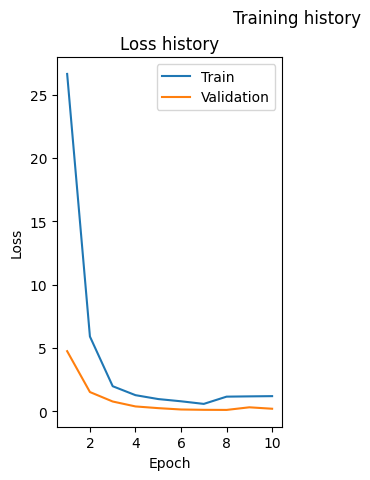

In [172]:
def print_history(history):
	absciss = np.arange(1, len(history["train"]["loss"])+1)
	plt.figure()
	plt.suptitle("Training history")
	plt.subplot(121)
	plt.title("Loss history")
	plt.plot(absciss, history["train"]["loss"], label="Train")
	plt.plot(absciss, history["val"]["loss"], label="Validation")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.show()
print_history(history)

In [173]:
model_3 = LSTM(in_dim, hidden_dim, out_dim, sequence_length).to(mode["device"])
optimizer = optimizer = optim.Adam(model_3.parameters(), lr=lr, weight_decay=regularization)
error_criterion = nn.MSELoss().to(mode["device"])
history = fit(model=model_3, loss_function=error_criterion, optimizer=optimizer, data_loader=data_loader, num_epochs=num_epochs, mode=mode)



Training the model:

Epoch 1


100%|██████████| 346/346 [00:05<00:00, 64.90it/s]


train loss: 26.11647562447712     


100%|██████████| 104/104 [00:00<00:00, 192.70it/s]


val loss: 4.541318722295412     

Epoch 2


100%|██████████| 346/346 [00:05<00:00, 62.89it/s]


train loss: 6.074595301091652     


100%|██████████| 104/104 [00:00<00:00, 216.61it/s]


val loss: 1.2911333521728308     

Epoch 3


100%|██████████| 346/346 [00:05<00:00, 63.23it/s]


train loss: 2.179287674548552     


100%|██████████| 104/104 [00:00<00:00, 208.10it/s]


val loss: 0.4859039474532896     

Epoch 4


100%|██████████| 346/346 [00:05<00:00, 62.55it/s]


train loss: 1.2666600930094525     


100%|██████████| 104/104 [00:00<00:00, 218.37it/s]


val loss: 0.3577367299288756     

Epoch 5


100%|██████████| 346/346 [00:05<00:00, 65.35it/s]


train loss: 1.2037563554913084     


100%|██████████| 104/104 [00:00<00:00, 231.83it/s]


val loss: 0.20455747949381886     

Epoch 6


100%|██████████| 346/346 [00:05<00:00, 65.41it/s]


train loss: 0.7628936818551044     


100%|██████████| 104/104 [00:00<00:00, 209.62it/s]


val loss: 0.17626068811551374     

Epoch 7


100%|██████████| 346/346 [00:05<00:00, 63.94it/s]


train loss: 0.6509312106837027     


100%|██████████| 104/104 [00:00<00:00, 211.41it/s]


val loss: 0.133360650112049     

Epoch 8


100%|██████████| 346/346 [00:05<00:00, 62.22it/s]


train loss: 0.5371242616122647     


100%|██████████| 104/104 [00:00<00:00, 215.82it/s]


val loss: 0.10434433262009019     

Epoch 9


100%|██████████| 346/346 [00:05<00:00, 61.91it/s]


train loss: 3.9112339821413484     


100%|██████████| 104/104 [00:00<00:00, 213.31it/s]


val loss: 0.6999857147301618     

Epoch 10


100%|██████████| 346/346 [00:05<00:00, 64.23it/s]


train loss: 0.867831386296414     


100%|██████████| 104/104 [00:00<00:00, 209.35it/s]


val loss: 0.2815964885438733     


100%|██████████| 45/45 [00:00<00:00, 202.57it/s]


Evaluating the model:
test loss: 0.3758074612966899     


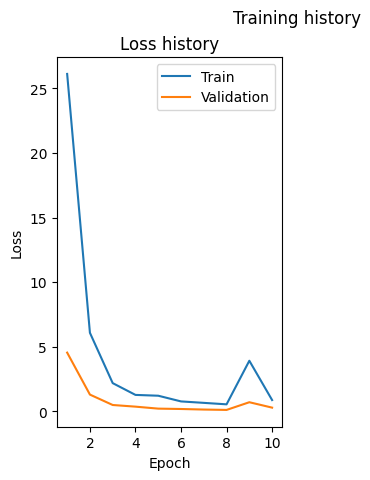

In [174]:
def print_history(history):
	absciss = np.arange(1, len(history["train"]["loss"])+1)
	plt.figure()
	plt.suptitle("Training history")
	plt.subplot(121)
	plt.title("Loss history")
	plt.plot(absciss, history["train"]["loss"], label="Train")
	plt.plot(absciss, history["val"]["loss"], label="Validation")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.show()
print_history(history)

In [175]:
def predict(model, loader, model_name):
    preds = []
    ground_truth = []
    model.eval()
    df = pd.DataFrame()
    with torch.no_grad():
        for X, y in loader:
            y_pred = model(X.to(mode["device"]))
            preds.append([tensor.item() for tensor in y_pred])
            ground_truth.append([tensor.item() for tensor in y])
    preds = [item for sublist in preds for item in sublist]
    ground_truth = [item for sublist in ground_truth for item in sublist]

    df["pred"] = preds
    df["ground_truth"] = ground_truth
    df.index = test.tail(len(y_test)).index

    mae = mae_sklearn(preds, ground_truth)
    mse = mse_sklearn(preds, ground_truth, squared=True)
    rmse = mse_sklearn(preds, ground_truth, squared=False)

    print(f"Performance measuers with unseen data on {model_name}")
    print("MAE: {:.2f}".format(mae), "MSE: {:.2f}".format(mse), "RMSE: {:.2f}".format(rmse))
    print()

    return df

In [178]:
model_1_history = predict(model_1, test_dataloader, "FCN")
model_2_history = predict(model_2, test_dataloader, "LSTM")
model_3_history = predict(model_3, test_dataloader, "LSTM Attention")

Performance measuers with unseen data on FCN
MAE: 0.87 MSE: 14.47 RMSE: 3.80

Performance measuers with unseen data on LSTM
MAE: 0.35 MSE: 0.27 RMSE: 0.52

Performance measuers with unseen data on LSTM Attention
MAE: 0.34 MSE: 0.38 RMSE: 0.61



In [179]:
import cufflinks as cf
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

model_3_history.iplot()